# Foundations of Deep Learning - Project

*Marco Donzella 829358, Rebecca Picarelli 834286*

## 1. The dataset

Il dataset scelto per le analisi è CIFAR-10, scaricabile al seguente link: https://www.cs.toronto.edu/~kriz/cifar-10-matlab.tar.gz

Per effettuare dei test, è possibile utilizzare la versione di tale dataset presente su tensorflow.

*N.B.: assicurarsi di aver cambiato il tipo di runtime da CPU a GPU!*

In [ ]:
# Runtime -> change runtime type -> GPU
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from skimage import io # Input/output
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


É necessario modificare il tipo di codifica della variabile risposta *y* nel formato *one-hot-encoding*. In questo modo la variabile sarà accettata come input nelle rete neurali implementate successivamente. 

Non sarà necessario applicare alcun tipo di preprocessing al dataset, in quanto tutte le fasi di eleborazione e pulizia necessarie saranno definite all'interno del modello.

In [ ]:
yc_train = keras.utils.to_categorical(y_train, 10) 
yc_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

## 2. Transfer learning

Per cercare di arrivare ad avere risultati migliori, si decide di procedere con una tecnica di apprendimento detta *transfer learning*, che permette di lavorare con reti pre-addestrate sul problema in esame, trovando un "compromesso" tra la rete che si sceglierà di usare come base e la struttura della rete necessaria per risolvere il problema di classificazione.

Viene istanziata la rete *InceptionResNetV2* per risolvere il problema di classificazione.
Tale rete è stata scelta per via del buon compromesso tra numero di parametri stimati ed accuracy. Di seguito un link con le principali caratteristiche della rete: https://keras.io/api/applications/inceptionresnetv2/.

In [ ]:
base_net = keras.applications.InceptionResNetV2(                      
    include_top=False,
    weights="imagenet", # pre-trained model
    input_shape=(299,299,3))

219070464/219055592 [==============================] - 2s 0us/step


Di seguito viene riportata la struttura della rete di base scelta:

In [ ]:
base_net.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [ ]:
base_net.trainable=False # freeze dei layer che non si vogliono modificare

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))
input = keras.layers.Lambda(lambda image: tf.image.resize(image, (299,299)))(inputs) # change the size of the input
data_augmentation = keras.Sequential([
                                      keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                                      keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                                      keras.layers.experimental.preprocessing.RandomRotation(0.1)
                                      #keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3))
])
x = data_augmentation(input)
x = keras.applications.inception_resnet_v2.preprocess_input(input)        
x = base_net(x, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='swish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(128, activation='swish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

net = keras.Model(inputs=inputs, outputs=outputs)

Di seguito viene riportata la struttura della nuova rete implementata:

In [ ]:
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                             

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer = keras.optimizers.Adam(learning_rate=0.001), 
              metrics = ['accuracy'])

In [ ]:
history = net.fit(x_train, yc_train, batch_size=256, epochs=4, verbose=1,
          validation_data=(x_test, yc_test))

Epoch 1/4
196/196 [==============================] - 634s 3s/step - loss: 0.4193 - accuracy: 0.8703 - val_loss: 0.3082 - val_accuracy: 0.8986
Epoch 2/4
196/196 [==============================] - 597s 3s/step - loss: 0.2962 - accuracy: 0.9024 - val_loss: 0.2897 - val_accuracy: 0.9037
Epoch 3/4
196/196 [==============================] - 639s 3s/step - loss: 0.2647 - accuracy: 0.9129 - val_loss: 0.2598 - val_accuracy: 0.9142
Epoch 4/4
196/196 [==============================] - 594s 3s/step - loss: 0.2468 - accuracy: 0.9174 - val_loss: 0.2553 - val_accuracy: 0.9159


Viene riportato graficamente l'andamento dell'accuracy e della loss durante le epoche. In questo caso sono state utilizzate solo 4 epoche per via dei tempi computazionali.

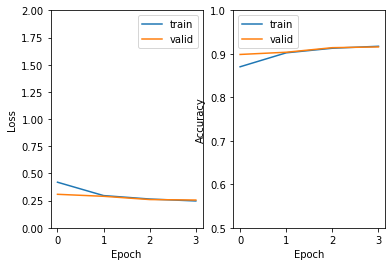

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid']);

Ora si valuta il modello finale sul dataset di test:

In [ ]:
# Evaluation
score = net.evaluate(x_test, yc_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2553010880947113
Test accuracy: 0.9158999919891357


In [ ]:
# Inference
yc_pred = net.predict(x_test)
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1000
           1       0.93      0.97      0.95      1000
           2       0.97      0.83      0.90      1000
           3       0.84      0.87      0.86      1000
           4       0.85      0.93      0.89      1000
           5       0.91      0.89      0.90      1000
           6       0.92      0.94      0.93      1000
           7       0.96      0.94      0.95      1000
           8       0.92      0.96      0.94      1000
           9       0.96      0.90      0.93      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Confusion matrix:
[[928   4   4   1   4   0   1   2  49   7]
 [  5 967   0   2   0   1   1   1   4  19]
 [ 28   0 832  35  61   8  25   7   4   0]
 [  8   2   7 869  24  54  26   2   6   2]
 [  5   0   5  12 931   6  1

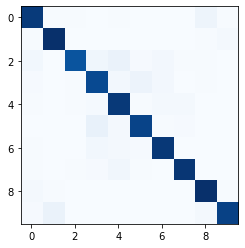

In [ ]:
# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

## Save the model

Si salva il modello addestrato, così da poterlo utilizzare per sviluppi futuri:

In [ ]:
net.save('my_net.h5')